In [26]:
import os
import warnings

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [27]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

In [28]:
np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

In [29]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [30]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Data Exploration

We have multiple houses, and we want to predict their **market price**.
So we are going to explore the features that we have.

In [48]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv')

In [34]:
print('Number of samples: ', train_set.shape[0])
print('Number of features: ', test_set.shape[1])

Number of samples:  5432
Number of features:  21


In [49]:
train_set.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
index,,,,,,,,,,,,,,,,,,,,,
0,Aberfeldie,241 Buckley St,4,h,1380000.0,VB,Nelson,12/08/2017,7.5,3040.0,4.0,2.0,2.0,766.0,NaN,NaN,Moonee Valley,-37.75595,144.90551,Western Metropolitan,1543.0
1,Northcote,67 Charles St,2,h,1100000.0,SP,Jellis,20/05/2017,5.5,3070.0,2.0,1.0,1.0,189.0,NaN,NaN,Darebin,-37.77670,144.99240,Northern Metropolitan,11364.0
2,Balwyn North,42 Maud St,3,h,1480000.0,PI,Jellis,15/10/2016,9.2,3104.0,3.0,1.0,4.0,605.0,116.0,1950.0,Boroondara,-37.79510,145.06960,Southern Metropolitan,7809.0


In [51]:
def diplay_unique_values(df: pd.DataFrame):
    print('')
    for column in train_set.columns.values:
        print(f'{column.capitalize()} - {train_set[column].dtype} - ', train_set[column].nunique())
    
diplay_unique_values(train_set)

Suburb - object -  292
Address - object -  5400
Rooms - int64 -  8
Type - object -  3
Price - float64 -  1458
Method - object -  5
Sellerg - object -  203
Date - object -  58
Distance - float64 -  194
Postcode - float64 -  187
Bedroom2 - float64 -  11
Bathroom - float64 -  9
Car - float64 -  10
Landsize - float64 -  1131
Buildingarea - float64 -  435
Yearbuilt - float64 -  121
Councilarea - object -  32
Lattitude - float64 -  3568
Longtitude - float64 -  3790
Regionname - object -  8
Propertycount - float64 -  289


In [47]:
# In the case of the Addres, we can see that would not provide a lot of information to have such a categorical variable
train_set.drop(['Address'], axis=1, inplace=True)
test_set.drop(['Address'], axis=1, inplace=True)

### Categorical Variables

In [52]:
# Can take a closer look to the object ones
train_set.select_dtypes(include=['object']).head(3)

,Suburb,Address,Type,Method,SellerG,Date,CouncilArea,Regionname
index,,,,,,,,
0,Aberfeldie,241 Buckley St,h,VB,Nelson,12/08/2017,Moonee Valley,Western Metropolitan
1,Northcote,67 Charles St,h,SP,Jellis,20/05/2017,Darebin,Northern Metropolitan
2,Balwyn North,42 Maud St,h,PI,Jellis,15/10/2016,Boroondara,Southern Metropolitan


<AxesSubplot: xlabel='count', ylabel='Type'>

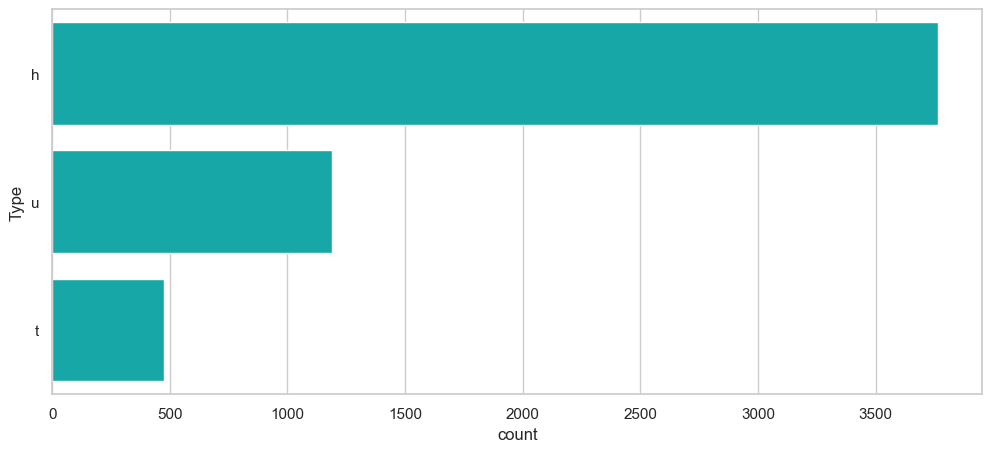

In [53]:
sns.countplot(
    y='Type',
    data=train_set,
    color='c'
)

We have the different types:
- **h**: hourse, cottage, villa, semi, terrace
- **u**: unit, duplex
- **t**: townhouse

And we can see that the majority of them are of type *h*.

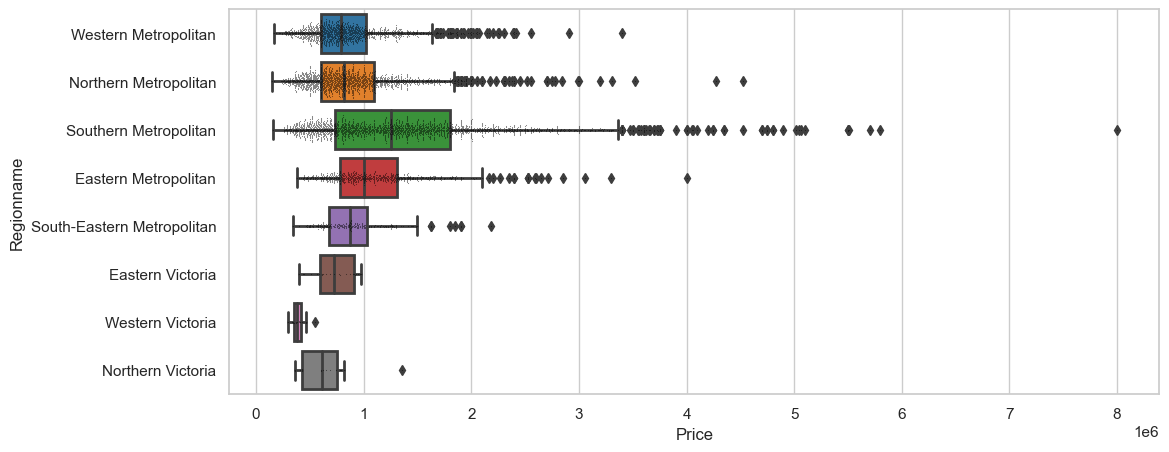

In [61]:
sns.boxplot(
    x='Price',
    y='Regionname',
    data=train_set,
)

sns.swarmplot(
    x="Price", 
    y="Regionname", 
    data=train_set, 
    color='black', 
    alpha = 0.5,
    size=0.8
);

We can see that there is a difference in the visualization on the distribution.

We might have to do a test to know if this difference of distributions is important to take into consideration. For this, we could make an ANOVA test.

In [62]:
# Consider normality of price distribution in each group to apply ANOVA 

## TODO's

- With one hot encoding, the U of Type could be skipped (multi-collinearity if we have all of them)
- Create model for predicting building area / landsize & infer nan -> LR for type of house and landsize
- Buildyear based on KNN, 
- Filter by the outliers 
- Each model for division
- Train/val split
- Data with same ranges as test (and same parameters for conversion/normalization)